## Imports

In [1]:
import pandas as pd

## Loading Data

In [2]:
df = pd.read_csv('../input/vehicle-images-dataset/vehcle_img_data.csv', low_memory=False)
df.shape

(77980, 10)

## Cheking na values

In [3]:
df.isna().sum()

Image_Path          2
Brand               0
Model               1
Edition         65742
Year                0
Condition           0
Transmission        1
Body             1224
Fuel                0
Capacity          205
dtype: int64

#### 

#### we have two null paths

In [4]:
df = df[~df.Image_Path.isnull()]

## Visualisation

In [5]:
import matplotlib.pyplot as plt

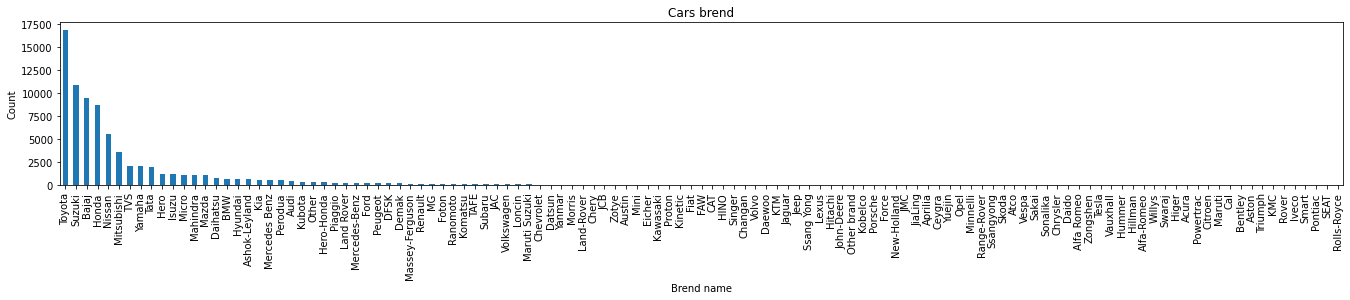

In [6]:
df.Brand.value_counts().plot(kind='bar', figsize=(23, 3))
# commenting the plot 
plt.title("Cars brend")
plt.xlabel("Brend name")
plt.ylabel("Count"); 

### Consediring only top N brends

In [7]:
N = 4
top_NBrands = df.Brand.value_counts()[:N].index
top_NBrands

Index(['Toyota', 'Suzuki', 'Bajaj', 'Honda'], dtype='object')

In [8]:
df_NB = df[df.Brand.isin(top_NBrands)] 

### Fixing paths

In [9]:
df_NB.Image_Path = '../input/vehicle-images-dataset/vehicle_images/' + df_NB.Image_Path.str.replace('./','', regex=False)
df_NB.Image_Path

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0        ../input/vehicle-images-dataset/vehicle_images...
4        ../input/vehicle-images-dataset/vehicle_images...
5        ../input/vehicle-images-dataset/vehicle_images...
6        ../input/vehicle-images-dataset/vehicle_images...
8        ../input/vehicle-images-dataset/vehicle_images...
                               ...                        
77972    ../input/vehicle-images-dataset/vehicle_images...
77974    ../input/vehicle-images-dataset/vehicle_images...
77975    ../input/vehicle-images-dataset/vehicle_images...
77978    ../input/vehicle-images-dataset/vehicle_images...
77979    ../input/vehicle-images-dataset/vehicle_images...
Name: Image_Path, Length: 45984, dtype: object

### Cheking for non existing paths

In [10]:
import os
x = os.listdir('../input/vehicle-images-dataset/vehicle_images/vehicle_images/')
len(x)

77977

In [11]:
x[0]

'1636034671579_Bajaj Discover 100 2011 Motorbike.jpg'

In [12]:
t = list(df_NB.Image_Path.str.replace('../input/vehicle-images-dataset/vehicle_images/vehicle_images/','', regex=False))


In [13]:
no_image = []
for index, image in enumerate(t):
    if image not in x:
        no_image.append(index)

In [14]:
no_image

[44951]

#### indexs of paths 

### Deleting the non existing images

In [15]:
df_NB.drop(df_NB.iloc[no_image, :].index, axis=0, inplace=True);

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
df_NB.shape

(45983, 10)

## Features / Target

In [17]:
X = df_NB.Image_Path
y = df_NB.Brand

In [18]:
X.shape, y.shape

((45983,), (45983,))

In [19]:
from IPython.display import display, Image

### showing an image simple
 

Toyota


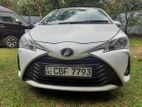

In [20]:
print(y[4])
Image(X[4]) 

## Data Engineering

In [21]:
def simple_transformer(column):
    """
    this transformer will convert any giving categoricol column to numerical.
    """
    # all unique values for column 
    names = column.value_counts().index
    # how size of them
    size = len(names)
    # create dict value:name / ex: {1:'category 1'}... 
    replacement = dict(zip(names, range(size)))
    # aplly the changes
    column.replace(replacement, inplace=True)
    return replacement

In [22]:
simple_transformer(y)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


{'Toyota': 0, 'Suzuki': 1, 'Bajaj': 2, 'Honda': 3}

In [23]:
y.head()

0    0
4    0
5    0
6    0
8    0
Name: Brand, dtype: int64

## Modeling

In [24]:
from sklearn.model_selection import train_test_split

# creating test and train data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True, stratify=y)

In [25]:
# create validation data from train
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True, stratify=y_train)

In [26]:
import tensorflow as tf

In [27]:
# Check GPU 
print("GPU available" if tf.config.list_physical_devices("GPU") else "not available");

GPU available


2021-11-24 17:47:09.575744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 17:47:09.716338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 17:47:09.717375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [28]:
# image size
IMG_SIZE = 220

def process_image(image_path):
    """
    Convert an image file path and turns it into a Tensor.
    """
    # Read an image from path
    image = tf.io.read_file(image_path)
    # Decode the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired size IMG_SIZE
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

In [29]:
# function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [30]:
import numpy as np

In [31]:
# batch size of 32 is a good default
BATCH_SIZE = 256

# function to turn data into batches
def create_data_batches(x, y, batch_size=BATCH_SIZE):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    """
    print("Creating data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels  
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the data into batches
    
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [32]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val)
# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)

Creating data batches...
Creating data batches...


2021-11-24 17:47:10.595212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 17:47:10.597175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 17:47:10.598207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 17:47:10.599171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [33]:
from tensorflow.keras import layers, models

In [34]:
def create_model():
    """
    Function to build the model.    
    """
    # building the model
    data_augmentation = tf.keras.models.Sequential([
        layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)])
    
    model = models.Sequential([
                data_augmentation,
        
                layers.Conv2D(32, 5, padding='same', activation='relu'),
                layers.MaxPooling2D(),
        
                layers.Conv2D(32, 5, padding='same', activation='relu'),
                layers.MaxPooling2D(),
        
                layers.Conv2D(64, 3, padding='same', activation='relu'),
                layers.MaxPooling2D(),

                layers.Conv2D(64, 3, padding='same', activation='relu'),
                layers.MaxPooling2D(),
        
                layers.Conv2D(64, 3, padding='same', activation='relu'),
                layers.MaxPooling2D(),
                 
                layers.Flatten(),
                layers.Dense(512, activation='relu'),
                        
                layers.Dense(N, activation='softmax')])
    
    model.compile(optimizer= tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Creating our model 
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 220, 220, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)       

In [35]:
from tensorflow import keras

In [36]:
# Create early stopping (callback function) (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10) # stops after 3 rounds of no improvements
# number of epochs
NUM_EPOCHS = 100

# function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    history = model.fit(
        train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        callbacks= [early_stopping])
  
    return model, history

# Fit the model to the data
model, history = train_model()

2021-11-24 17:47:15.821632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-24 17:47:19.423068: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


115/115 [==============================] - 156s 1s/step - loss: 1.2048 - accuracy: 0.4527 - val_loss: 1.0559 - val_accuracy: 0.5329
Epoch 2/100
115/115 [==============================] - 40s 348ms/step - loss: 1.0227 - accuracy: 0.5497 - val_loss: 0.9033 - val_accuracy: 0.6136
Epoch 3/100
115/115 [==============================] - 41s 353ms/step - loss: 0.9399 - accuracy: 0.5974 - val_loss: 0.8435 - val_accuracy: 0.6363
Epoch 4/100
115/115 [==============================] - 40s 348ms/step - loss: 0.8636 - accuracy: 0.6339 - val_loss: 0.7810 - val_accuracy: 0.6695
Epoch 5/100
115/115 [==============================] - 40s 348ms/step - loss: 0.8177 - accuracy: 0.6525 - val_loss: 0.7467 - val_accuracy: 0.6878
Epoch 6/100
115/115 [==============================] - 41s 355ms/step - loss: 0.7654 - accuracy: 0.6772 - val_loss: 0.7120 - val_accuracy: 0.7081
Epoch 7/100
115/115 [==============================] - 41s 355ms/step - loss: 0.7150 - accuracy: 0.7011 - val_loss: 0.6766 - val_accuracy:

## Accuracy Evaluation


In [37]:
import matplotlib.pyplot as plt

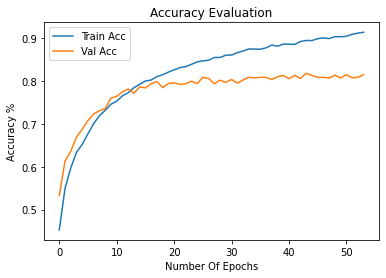

In [38]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Number Of Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy Evaluation')
plt.legend()
plt.show()

## Summarize history for loss


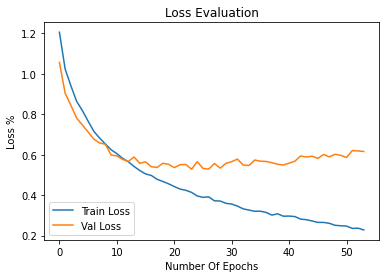

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Evaluation')
plt.ylabel('Loss %')
plt.xlabel('Number Of Epochs')
plt.legend(['Train Loss', 'Val Loss'], loc='lower left')
plt.show()

## Evaluating on test data

In [40]:
# model accuracy on test data
test_data = create_data_batches(X_test, y_test)
model.evaluate(test_data)

Creating data batches...
36/36 [==============================] - 38s 1s/step - loss: 0.6292 - accuracy: 0.8135


[0.6291989088058472, 0.8135261535644531]